# Evaluation

The goal of this lab is to introduce you to techniques for evaluating your trained models. The motivation is to be able to select the model that has the best (expected) out-of-sample prediction and to assess the quality of the model.

## 1. Model Selection in a holdout setting

We will work with the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a> data set. The iris data set consists out of $4$ features (sepal length, sepal width, petal length, petal width) of three kinds of flowers in the iris family: iris setosa, iris versicolor, iris virginica. Our version of the data set has 150 data points with 50 for each class.

In [10]:
# Load the data
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()

print('Loaded {} data points'.format(len(iris.data)))

X, y = iris.data, iris.target

''' zip() is a function that combines two sequences into a single sequence of tuples.
    zip() function pairs each number from range(3) with the corresponding class label from iris.target_names
    The list() function then converts these pairs into a list format. 
    The format() method takes this list and inserts it into the {} placeholder, 
    resulting in the output that shows each class label with its corresponding numeric code (0, 1, 2)'''

print('Class labels: {}'.format(list(zip(range(3), iris.target_names))))

Loaded 150 data points
Class labels: [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


We try to classify the iris versicolor with the help of the first two features.

In [11]:
import numpy as np

X_versi = X[:, :2] #contains all rows of X but only the first two columns sepal length and sepal width
y_versi = np.zeros(len(y)) #initializes a new array y_versi with the same length as y (the target array)
y_versi[y == 1] = 1 #marks all versicolor samples with a 1, while all other samples (setosa and virginica) remain marked as 0 in y_versi

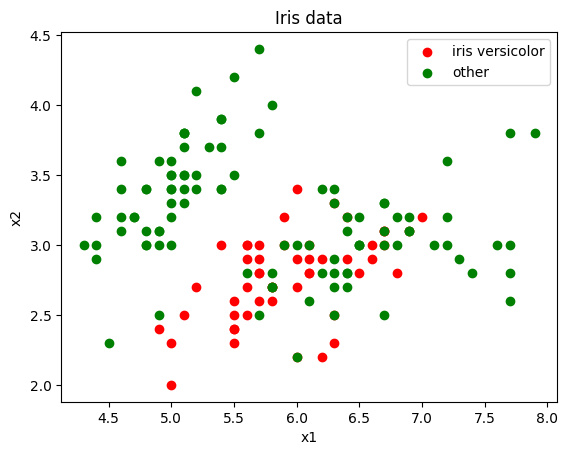

In [12]:
# plot iris data with two features
plt.scatter(X_versi[y_versi == 1, 0], X_versi[y_versi == 1, 1], c='red', label='iris versicolor')
plt.scatter(X_versi[y_versi == 0, 0], X_versi[y_versi == 0, 1], c='green', label='other')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title('Iris data')
plt.legend()

We split the data into a train and test (holdout) set with a split ratio of 75% to 25%.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, test_size=0.25, random_state=3)

The following function is a little visualization helper that draws the values of the decision function on a heat map given a matplotlib axe.

In [14]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    except AttributeError:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

We now train a SVM classifier on the training data and plot its decision boundary.

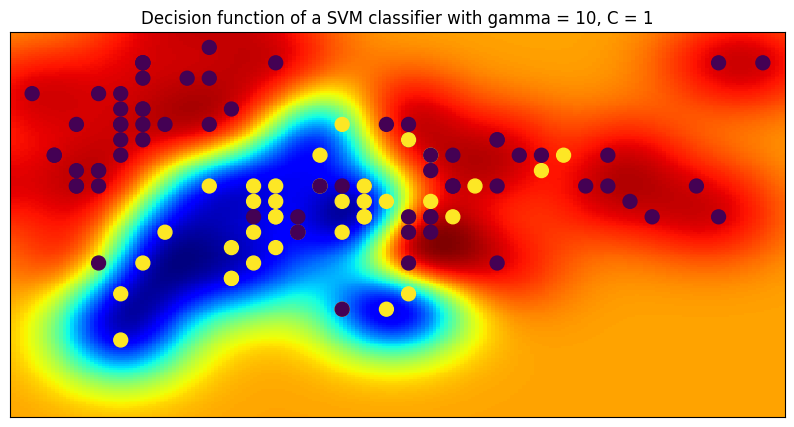

In [15]:
from sklearn.svm import SVC

clf_svm = SVC(gamma=10, C=1, probability=True)
clf_svm.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(clf_svm, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = 1');

**Explanation**
- `SVC(gamma=10, C=1, probability=True)` creates an instance of the `SVC` class. The `gamma` parameter defines the influence of a single training example, with low values meaning 'far' and high values meaning 'close'. The `C` parameter trades off correct classification of training examples against maximization of the decision function's margin. With low values of `C`, the decision surface is smooth, while with high values, the decision surface bends to correctly classify all training data. `probability=True` enables the probability estimates, which are not available by default because they are computationally expensive.
- `clf_svm.fit(X_train, y_train)` trains the SVM classifier using the training data `X_train` and the target labels `y_train`.
- `plt.figure(figsize=(10, 5))` creates a new figure for plotting with a width of 10 inches and a height of 5 inches.
- `fig.add_subplot(111)` adds a subplot to the figure. The `111` is a 3-digit integer where the first digit is the number of rows, the second is the number of columns, and the third is the index of the subplot (starting at 1).
- `show_decision_function(clf_svm, ax)` calls the previously defined function `show_decision_function` to visualize the decision boundary of the trained SVM classifier on the subplot `ax`.
- `ax.set_title('...')` sets the title of the subplot to indicate the parameters of the SVM classifier being visualized.



```
clf_svm = SVC(gamma=10, C=1, probability=True)
```

- **`gamma`**: This parameter defines how far the influence of a single training example reaches. It affects the shape of the decision boundary. If `gamma` is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with `C` will be able to prevent overfitting. When `gamma` is very small, the model is too constrained and cannot capture the complexity or "shape" of the data. The value of `gamma` can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

  - **High `gamma`**: The model will try to fit the training data as well as possible, which can lead to overfitting. A high `gamma` value leads to a more complex model that may capture noise in the data.
  - **Low `gamma`**: The model will have a smoother decision boundary, which might not capture the complexities of the data, leading to underfitting.

- **`C`**: This parameter trades off correct classification of training examples against maximization of the decision function's margin. `C` is the penalty parameter of the error term. It controls the trade-off between smooth decision boundary and classifying the training points correctly. A large `C` gives you low bias and high variance. Low bias because you penalize the cost of missclasification a lot. A small `C` gives you higher bias and lower variance.

  - **High `C`**: The SVM classifier will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Thus, a higher `C` can lead to a model that is less general (more overfitting) to the training data.
  - **Low `C`**: A very small value of `C` will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. Therefore, for very small values of `C`, the optimizer will choose a larger-margin separating hyperplane, which means a simpler model that might not capture all nuances in the data.

- **`probability=True`**: This parameter enables probability estimates. When set to `True`, the `SVC` class uses Platt scaling: logistic regression on the SVM's scores, fitted by an additional cross-validation on the training data. This can be computationally expensive as it involves cross-validation and fitting additional models.

In summary, `gamma` determines the curvature of the decision boundary, and `C` determines the penalty for misclassifying points. Together, they control the trade-off between bias and variance in the model. Adjusting these parameters is essential to find the right balance that allows the SVM to generalize well to unseen data.

#### Exercise 1.1 (Performance measures)
Classify the test data and evaluate the classification performance of the trained model 'clf_svm' using the scikit-learn metrics package. Compare various metrics (classification accuracy, precision, recall, f-score), interpret their values and argue which of them might be the most meaningful to report.

In [16]:
from sklearn import metrics

# Assume X_test and y_test are the features and labels of the test data.
y_pred = clf_svm.predict(X_test)

# Calculate various performance metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f_score = metrics.f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F-score: {f_score:.2f}")

Accuracy: 0.76
Precision: 0.67
Recall: 0.50
F-score: 0.57


***Interpretation:***

- **Accuracy**: The accuracy of 0.76 indicates that the model correctly predicted 76% of the test data. 

- **Precision**: A precision of 0.67 means that when the model predicts the positive class (in this case, Iris versicolor), it is correct approximately 67% of the time. This implies that 33% of the time, other species might be incorrectly identified as versicolor.

- **Recall**: The recall of 0.50 indicates that the model correctly identifies 50% of the actual positive cases (versicolor). This means that half of the versicolor instances in the test set were missed by the model.

- **F-score**: An F-score of 0.57 is a measure that combines precision and recall. It is not as high as it could be, indicating that the model is not perfectly balanced in terms of precision and recall. This score suggests that the model is more conservative in predicting the positive class, possibly at the cost of missing out on some actual positive instances.

In the context of classifying Iris versicolor, these metrics suggest that while the model is fairly accurate overall, it tends to miss a significant number of versicolor instances (as indicated by the recall). The precision indicates that among the instances it does predict as versicolor, a third are actually of another species. 

The most meaningful metric to report would depend on the cost associated with misclassifications. If it is more important not to misclassify other species as versicolor, then precision would be the key metric. If it is more critical to ensure all versicolor instances are identified, even at the risk of including some other species, then recall would be more important. If a balance is needed, then the F-score would be the metric to consider.

#### Exercise 1.2 (ROC curve)

To further evaluate the model, we want to plot a ROC (Receiver operating characteristic) curve and look at the AUC (area under the curve) value. Therefore, we provide a function "plot_roc_curves" that accepts increasing false positive rates (fprs) and true positive rates (tprs) and plots the curve for you. 

Please calculate the false and true positive rates of the classifier 'clf_svm' on the test data 'X_test' and draw the ROC curve by executing the function 'plot_roc_curves'. What does the ROC and AUC tell us about the classifier's performance?

In [17]:
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

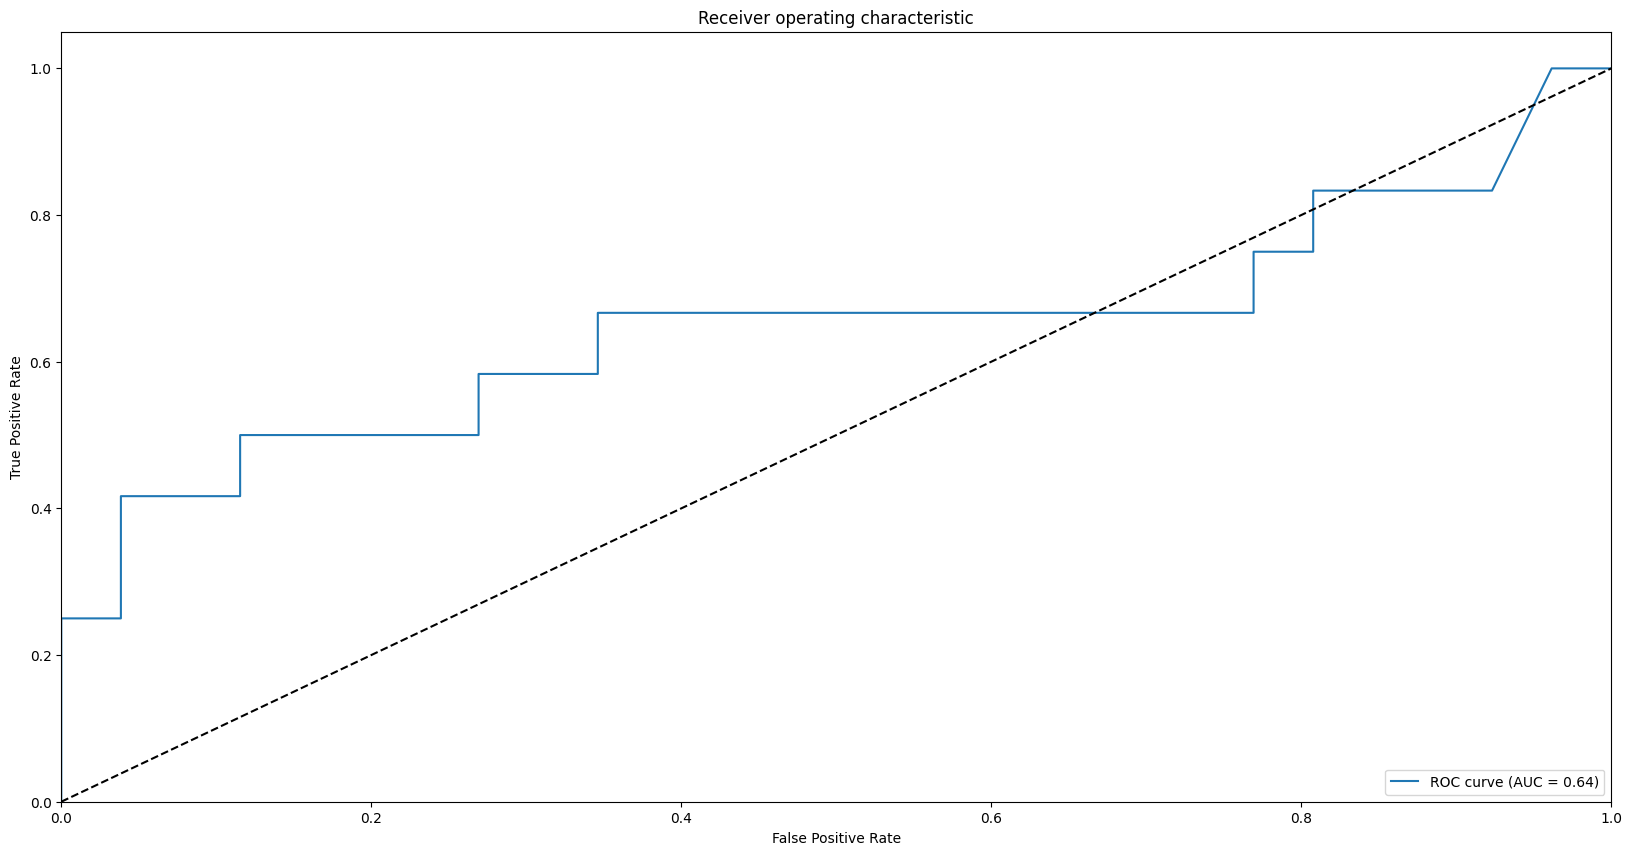

In [24]:
from sklearn.metrics import roc_curve, auc

# Predict the probabilities for the test data
y_scores = clf_svm.predict_proba(X_test)[:, 1]

fpr, tpr , thresholds = roc_curve(y_test, y_scores)

# plot the curve
plot_roc_curves([fpr], [tpr])

#### Exercise 1.3 (Model comparison)

Train four more SVM models on the training data by varying the regularization parameter $C$ (the gamma parameter can be set to 10 again). Put the models into a list 'clfs' using the append method. You can add a name to each classifier by setting clf.name = "some description" to keep track of the configuration.

In [25]:
clfs = []

# List to hold the classifiers
clfs = []

# Different C values to try
C_values = [0.1, 1, 10, 100]

for C_val in C_values:
    # Create an SVM classifier with a specific C value and gamma set to 10
    clf = SVC(gamma=10, C=C_val, probability=True)
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Set a name for the classifier to keep track of the configuration
    clf.name = f"SVM with C={C_val}"
    
    # Add the classifier to the list
    clfs.append(clf)

Let's have a look at the decision functions of the four classifiers...

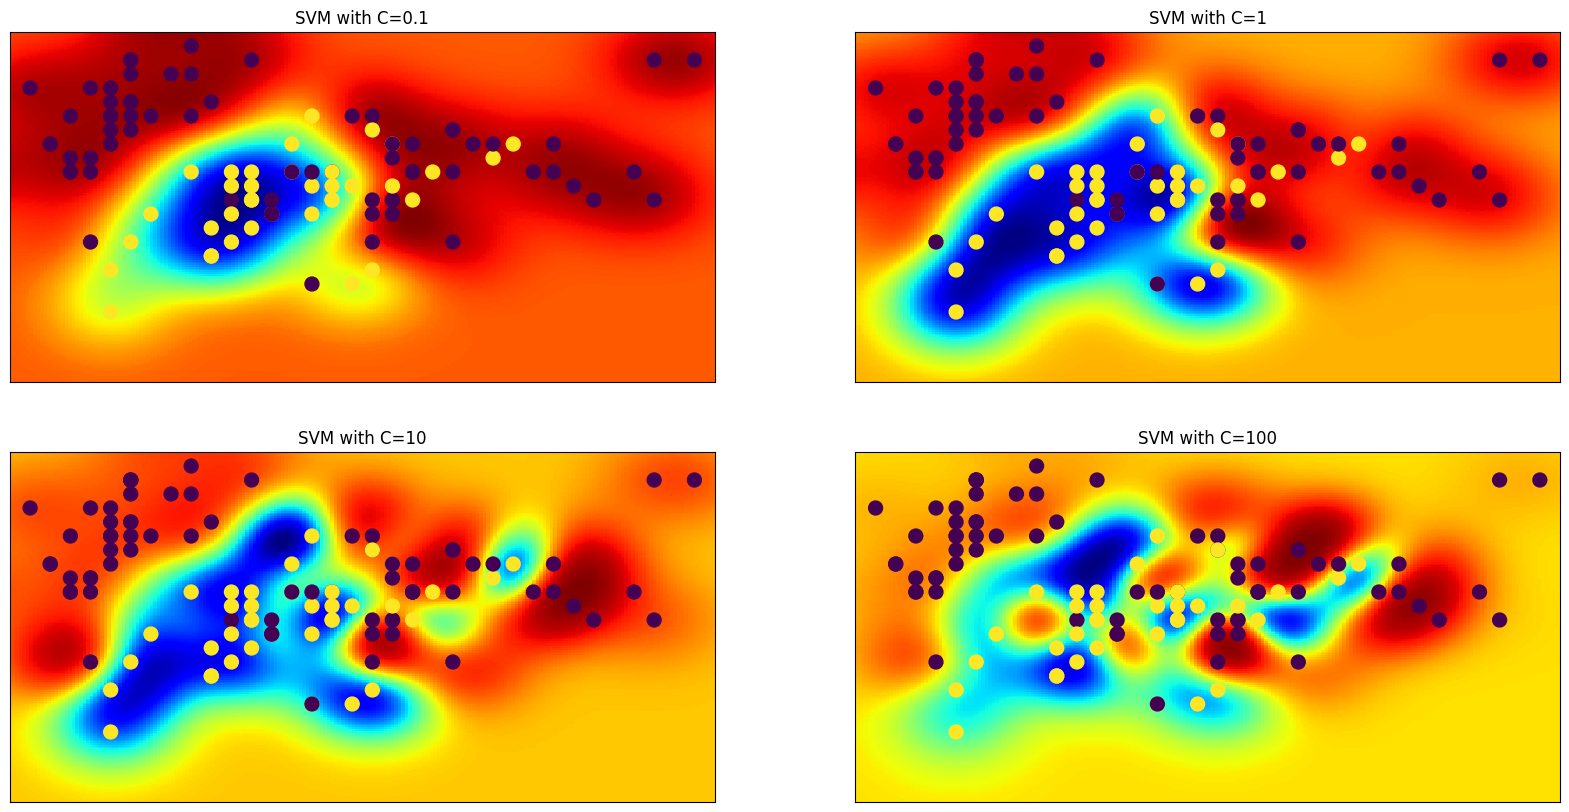

In [26]:
# visualize the decision functions of the four different classifiers
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for clf, ax in zip(clfs, axes.ravel()):
    show_decision_function(clf, ax)
    ax.set_title(clf.name)

... and draw the ROC curves.

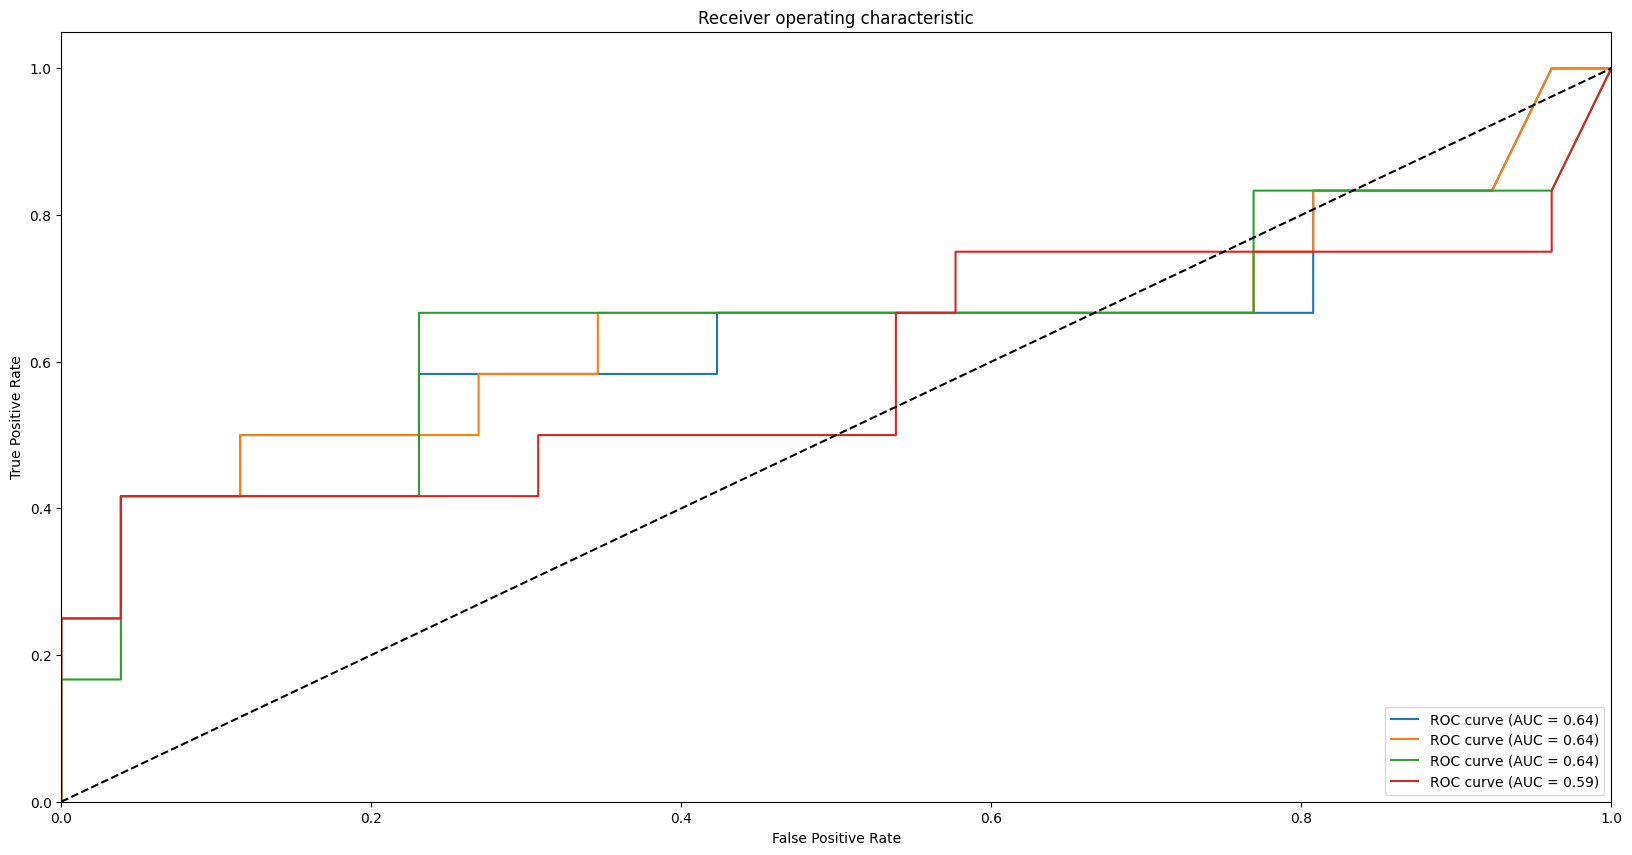

In [27]:
# draw the roc curves:

fprs, tprs = [], []

for clf in clfs:
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curves(fprs, tprs)

## 2. Hyperparameter Tuning

Many models have hyperparameters, parameters that can't directly be estimated from the data. They have to be manually tuned by the practioner, because there is no analytical formula available to calculate an appropriate value. One example is the regularization parameter $C$ in SVMs.

#### Exercise 2.1 (Nested cross-validation)

Train a SVM classifier for the detection of iris versicolor again, but this time with a proper tuning of the regularization parameter $C$ (you may set the gamma parameter to 10 again). Select a reasonable range of parameter values for $C$ and implement a nested cross-validation (as shown on the slides) by yourself. 

You can use the following helper function that creates a list of masks. Each mask can be used as an index set to select the test samples. The function accepts the number of samples *num_samples* in the dataset and the desired number of folds *k* as input parameters. Since the data is sorted by the labels the k-fold CV will likely have trouble with class imbalances in the some cases. So you should randomly shuffle the data before applying the masks.

In [ ]:
# helper function to create k-fold train-test-splits
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples / k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i*int(fold_size):(i+1)*int(fold_size)] = True
        masks.append(mask)
        
    return masks

# visualization of the splits created by 'create_kfold_mask'
masks = create_kfold_mask(150, 10)
plt.matshow(masks)

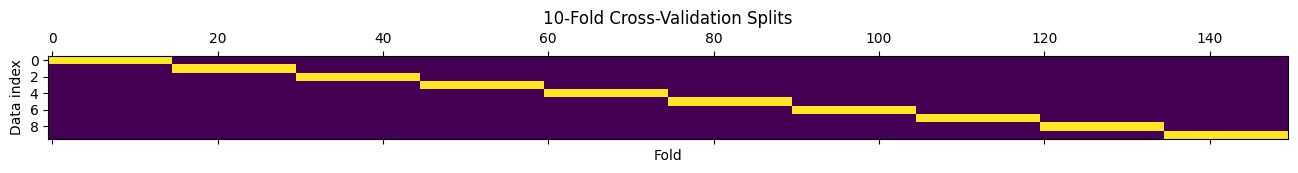

The average score across the outer folds is: 0.92


In [29]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming X, y are your data and labels
X, y = shuffle(X, y, random_state=0)

# Helper function to create k-fold train-test-splits
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples // k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i*int(fold_size):(i+1)*int(fold_size)] = True
        masks.append(mask)
        
    return masks

# Visualization of the splits created by 'create_kfold_mask'
masks = create_kfold_mask(len(y), 10)
plt.matshow(masks)
plt.xlabel('Fold')
plt.ylabel('Data index')
plt.title('10-Fold Cross-Validation Splits')
plt.show()

# Select a range of C values for hyperparameter tuning
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Nested cross-validation
outer_scores = []

for outer_mask in masks:
    # Split the data into training and test sets for the outer loop
    outer_train_X, outer_test_X = X[~outer_mask], X[outer_mask]
    outer_train_y, outer_test_y = y[~outer_mask], y[outer_mask]
    
    inner_scores = []
    for C_val in C_values:
        inner_clf = SVC(gamma=10, C=C_val)
        
        # Inner loop for hyperparameter tuning
        inner_masks = create_kfold_mask(len(outer_train_y), 5)
        for inner_mask in inner_masks:
            inner_train_X, inner_val_X = outer_train_X[~inner_mask], outer_train_X[inner_mask]
            inner_train_y, inner_val_y = outer_train_y[~inner_mask], outer_train_y[inner_mask]
            
            inner_clf.fit(inner_train_X, inner_train_y)
            inner_val_pred = inner_clf.predict(inner_val_X)
            inner_scores.append(accuracy_score(inner_val_y, inner_val_pred))

    # Average the scores for each C value
    average_inner_scores = [np.mean(inner_scores[i::len(C_values)]) for i in range(len(C_values))]

    # Select the best C value based on the averaged inner scores
    best_C_index = np.argmax(average_inner_scores)
    best_C = C_values[best_C_index]
    
    # Train a new model on the full outer training set using the best C value
    clf = SVC(gamma=10, C=best_C)
    clf.fit(outer_train_X, outer_train_y)
    
    # Evaluate the model on the outer test set
    outer_test_pred = clf.predict(outer_test_X)
    outer_scores.append(accuracy_score(outer_test_y, outer_test_pred))

# Average the outer scores to get an estimate of the model's performance
average_score = np.mean(outer_scores)
print(f"The average score across the outer folds is: {average_score:.2f}")
